In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils
from statsmodels.formula.api import ols

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

distance_threshold = 800
overlap_threshold = 0.05

In [2]:
basepath = r'../../../'
datpath = (r'../data_files')
# No savepath - this did not end up in the paper

In [3]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs+hipp_strs

In [4]:
alldat = pd.read_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'))
print(len(alldat))
c_by_source = pd.read_csv(os.path.join(datpath, 'good_wt_correlations.csv'))
print(len(c_by_source))

586
627


In [5]:
len(c_by_source[c_by_source['same secondary for <60% primary'] == True])

69

In [6]:
c_by_source.loc[c_by_source['transgenic_line_A'].isnull(), 'transgenic_line_A'] = 'C57Bl/6'
c_by_source.loc[c_by_source['transgenic_line_B'].isnull(), 'transgenic_line_B'] = 'C57Bl/6'

In [7]:
wt = c_by_source[c_by_source['transgenic_line_A'] == 'C57Bl/6']['match_A'].unique()
wt2 = c_by_source[c_by_source['transgenic_line_B'] == 'C57Bl/6']['match_B'].unique()
wt = np.append(wt, wt2)
print('wt: ', len(np.unique(wt)))
Emx = c_by_source[c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre']['match_A'].unique()
Emx2 = c_by_source[c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre']['match_B'].unique()
Emx = np.append(Emx, Emx2)
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = c_by_source[c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100']['match_A'].unique()
Rbp42 = c_by_source[c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100']['match_B'].unique()
Rbp4 = np.append(Rbp4, Rbp42)
print('Rbp4-Cre: ', len(np.unique(Rbp4)))
other = c_by_source[(c_by_source['transgenic_line_A'] != 'C57Bl/6') & 
                    (~c_by_source['transgenic_line_A'].isin(['Emx1-IRES-Cre', 
                                                             'Rbp4-Cre_KL100']))]['match_A'].unique()
other2 = c_by_source[(c_by_source['transgenic_line_B'] != 'C57Bl/6') & 
                    (~c_by_source['transgenic_line_B'].isin(['Emx1-IRES-Cre', 
                                                             'Rbp4-Cre_KL100']))]['match_B'].unique()
other = np.append(other, other2)
print('other: ', len(np.unique(other)))

wt:  88
Emx1-Cre:  53
Rbp4-Cre:  67
other:  0


In [8]:
Emx = c_by_source[(c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre') &
                     (c_by_source['Virus_A'] == 'SypEGFP')]['match_A'].unique()
Emx2 = c_by_source[(c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre') &
                     (c_by_source['Virus_B'] == 'SypEGFP')]['match_B'].unique()
Emx = np.append(Emx, Emx2)
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = c_by_source[(c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100') &
                     (c_by_source['Virus_A'] == 'SypEGFP')]['match_A'].unique()
Rbp42 = c_by_source[(c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100') &
                     (c_by_source['Virus_B'] == 'SypEGFP')]['match_B'].unique()
Rbp4 = np.append(Rbp4, Rbp42)
print('Rbp4-Cre: ', len(np.unique(Rbp4)))

Emx1-Cre:  27
Rbp4-Cre:  13


In [9]:
df = c_by_source[['match_A', 'match_B', 'transgenic_line_A', 'transgenic_line_B', 'Virus_A', 'Virus_B', 
                  'spearman_correlation']]
df['tl'] = df[['transgenic_line_A', 'transgenic_line_B']].apply(lambda x: '_'.join(x), axis=1)

for index, row in df.iterrows():
    if(row['tl'] == 'Rbp4-Cre_KL100_C57Bl/6'):
        df.loc[index, 'tl'] = 'C57Bl/6_Rbp4-Cre_KL100'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values
        df.loc[index,['Virus_A','Virus_B']] = df.loc[
                index,['Virus_B','Virus_A']].values
    if(row['tl'] == 'Emx1-IRES-Cre_C57Bl/6'):
        df.loc[index, 'tl'] = 'C57Bl/6_Emx1-IRES-Cre'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values
        df.loc[index,['Virus_A','Virus_B']] = df.loc[
                index,['Virus_B','Virus_A']].values
    if(row['tl'] == 'Rbp4-Cre_KL100_Emx1-IRES-Cre'):
        df.loc[index, 'tl'] = 'Emx1-IRES-Cre_Rbp4-Cre_KL100'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values
        df.loc[index,['Virus_A','Virus_B']] = df.loc[
                index,['Virus_B','Virus_A']].values
df['v'] = df[['Virus_A', 'Virus_B']].apply(lambda x: '_'.join(x), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [10]:
df['tl'].unique()

array(['Emx1-IRES-Cre_Rbp4-Cre_KL100', 'C57Bl/6_Rbp4-Cre_KL100',
       'Rbp4-Cre_KL100_Rbp4-Cre_KL100', 'Emx1-IRES-Cre_Emx1-IRES-Cre',
       'C57Bl/6_Emx1-IRES-Cre', 'C57Bl/6_C57Bl/6'], dtype=object)

In [11]:
df['v'].unique()

array(['SypEGFP_SypEGFP', 'EGFP_SypEGFP', 'SypEGFP_EGFP', 'EGFP_EGFP'],
      dtype=object)

In [12]:
# Make categorical variables for anova
df = df[['tl', 'v', 'spearman_correlation']]
df['tln']=df.tl.map({'C57Bl/6_C57Bl/6':1,'C57Bl/6_Rbp4-Cre_KL100':2, 'C57Bl/6_Emx1-IRES-Cre':3,
                    'Emx1-IRES-Cre_Rbp4-Cre_KL100':4, 'Emx1-IRES-Cre_Emx1-IRES-Cre':5,
                    'Rbp4-Cre_KL100_Rbp4-Cre_KL100':6})
df['vn']=df.v.map({'EGFP_EGFP':1,'EGFP_SypEGFP':2, 'SypEGFP_EGFP':3, 'SypEGFP_SypEGFP':4})
df.head()

,tl,v,spearman_correlation,tln,vn
0,Emx1-IRES-Cre_Rbp4-Cre_KL100,SypEGFP_SypEGFP,0.857022,4,4
1,C57Bl/6_Rbp4-Cre_KL100,EGFP_SypEGFP,0.806174,2,2
2,Emx1-IRES-Cre_Rbp4-Cre_KL100,SypEGFP_SypEGFP,0.974469,4,4
3,C57Bl/6_Rbp4-Cre_KL100,EGFP_SypEGFP,0.786528,2,2
4,C57Bl/6_Rbp4-Cre_KL100,EGFP_SypEGFP,0.891894,2,2


In [13]:
results = ols('spearman_correlation ~ C(tln)*C(vn)', df).fit()

In [14]:
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(tln),5.0,0.131609,0.026322,5.381981,0.000075
C(vn),3.0,0.027803,0.009268,1.894960,0.129198
C(tln):C(vn),15.0,0.135963,0.009064,1.853338,0.025110
Residual,610.0,2.983354,0.004891,NaN,NaN


In [15]:
# Remove interaction term because it was not significant and rerun
results = ols('spearman_correlation ~ C(tln) + C(vn)', df).fit()

In [16]:
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(tln),5.0,0.131609,0.026322,5.378391,0.000075
C(vn),3.0,0.027803,0.009268,1.893697,0.129392
Residual,618.0,3.024497,0.004894,NaN,NaN


In [17]:
# Only transgenic line is significant; virus is not

In [18]:
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.050
Model:                              OLS   Adj. R-squared:                  0.038
Method:                   Least Squares   F-statistic:                     4.072
Date:                  Thu, 19 Nov 2020   Prob (F-statistic):           9.72e-05
Time:                          19:58:34   Log-Likelihood:                 782.60
No. Observations:                   627   AIC:                            -1547.
Df Residuals:                       618   BIC:                            -1507.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8569      0.

In [19]:
results.diagn

{'jb': 72.21904028466149,
 'jbpv': 2.0789050681628424e-16,
 'skew': -0.7639780305374182,
 'kurtosis': 3.6555268520700883,
 'omni': 57.645489527521384,
 'omnipv': 3.0369734539975215e-13,
 'condno': 8.552314518358136,
 'mineigval': 10.751015032497305}

In [20]:
#Test homogeneity of variance between groups
stats.levene(df['spearman_correlation'][df['tln'] == 2][df['vn'] == 2],
             df['spearman_correlation'][df['tln'] == 3][df['vn'] == 2],
             df['spearman_correlation'][df['tln'] == 4][df['vn'] == 2],
            df['spearman_correlation'][df['tln'] == 5][df['vn'] == 2],
            df['spearman_correlation'][df['tln'] == 6][df['vn'] == 2],
             df['spearman_correlation'][df['tln'] == 4][df['vn'] == 3],
            df['spearman_correlation'][df['tln'] == 5][df['vn'] == 3],
            df['spearman_correlation'][df['tln'] == 6][df['vn'] == 3],
             df['spearman_correlation'][df['tln'] == 4][df['vn'] == 4],
            df['spearman_correlation'][df['tln'] == 5][df['vn'] == 4],
            df['spearman_correlation'][df['tln'] == 6][df['vn'] == 4])

LeveneResult(statistic=0.7202965516284426, pvalue=0.7049707964194352)

In [21]:
#test normality
stats.shapiro(results.resid)

(0.9609500169754028, 7.413594044214378e-12)

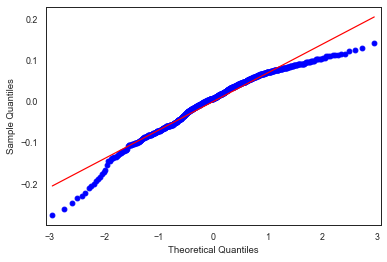

In [22]:
res = results.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [23]:
{'C57Bl/6_C57Bl/6':1,'C57Bl/6_Rbp4-Cre_KL100':2, 'C57Bl/6_Emx1-IRES-Cre':3,
                    'Emx1-IRES-Cre_Rbp4-Cre_KL100':4, 'Emx1-IRES-Cre_Emx1-IRES-Cre':5,
                    'Rbp4-Cre_KL100_Rbp4-Cre_KL100':6}

{'C57Bl/6_C57Bl/6': 1,
 'C57Bl/6_Rbp4-Cre_KL100': 2,
 'C57Bl/6_Emx1-IRES-Cre': 3,
 'Emx1-IRES-Cre_Rbp4-Cre_KL100': 4,
 'Emx1-IRES-Cre_Emx1-IRES-Cre': 5,
 'Rbp4-Cre_KL100_Rbp4-Cre_KL100': 6}

In [24]:
print(sm.stats.multicomp.pairwise_tukeyhsd(results.model.endog, df['tln'].values))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0142  0.541 -0.0383   0.01  False
     1      3   0.0142 0.5479 -0.0102 0.0386  False
     1      4  -0.0047    0.9 -0.0317 0.0223  False
     1      5   0.0386  0.019  0.0039 0.0732   True
     1      6   0.0084    0.9 -0.0248 0.0415  False
     2      3   0.0284 0.0058  0.0055 0.0513   True
     2      4   0.0095 0.8994 -0.0162 0.0351  False
     2      5   0.0527  0.001  0.0191 0.0863   True
     2      6   0.0225 0.3399 -0.0096 0.0546  False
     3      4  -0.0189 0.2956 -0.0448  0.007  False
     3      5   0.0244 0.3097 -0.0094 0.0582  False
     3      6  -0.0059    0.9 -0.0381 0.0264  False
     4      5   0.0433 0.0075  0.0076  0.079   True
     4      6    0.013 0.8799 -0.0212 0.0473  False
     5      6  -0.0302 0.2731 -0.0708 0.0103  False
---------------------------------------------------


In [25]:
c_by_source['spearman_correlation'].describe()

count    627.000000
mean       0.859518
std        0.071317
min        0.596485
25%        0.813910
50%        0.867519
75%        0.914891
max        0.997767
Name: spearman_correlation, dtype: float64

In [26]:
def corr(A,B):
    inj_unionize_A = mcc.get_structure_unionizes(experiment_ids = A,
                                               is_injection = True,
                                               structure_ids = ss)
    r_hemA = inj_unionize_A[inj_unionize_A['hemisphere_id'] == 2]['projection_volume'].sum()
    l_hemA = inj_unionize_A[inj_unionize_A['hemisphere_id'] == 1]['projection_volume'].sum()
    unionize_A = mcc.get_structure_unionizes(experiment_ids = A,
                                            is_injection = False,
                                            hemisphere_ids = [1,2],
                                            structure_ids = ss)
    if r_hemA > l_hemA:
        unionize_A.loc[unionize_A['hemisphere_id'] == 1, 'hemisphere_id'] = 0
        unionize_A.loc[unionize_A['hemisphere_id'] == 2, 'hemisphere_id'] = 1
        unionize_A.loc[unionize_A['hemisphere_id'] == 0, 'hemisphere_id'] = 2
    
    inj_unionize_B = mcc.get_structure_unionizes(experiment_ids = B,
                                               is_injection = True,
                                               structure_ids = ss)
    r_hemB = inj_unionize_B[inj_unionize_B['hemisphere_id'] == 2]['projection_volume'].sum()
    l_hemB = inj_unionize_B[inj_unionize_B['hemisphere_id'] == 1]['projection_volume'].sum()
    unionize_B = mcc.get_structure_unionizes(experiment_ids = B,
                                            is_injection = False,
                                            hemisphere_ids = [1,2],
                                            structure_ids = ss)
    if r_hemB > l_hemB:
        unionize_B.loc[unionize_B['hemisphere_id'] == 1, 'hemisphere_id'] = 0
        unionize_B.loc[unionize_B['hemisphere_id'] == 2, 'hemisphere_id'] = 1
        unionize_B.loc[unionize_B['hemisphere_id'] == 0, 'hemisphere_id'] = 2
        
    unionizes = pd.concat([unionize_A, unionize_B])
    unionizes.sort_values(by=['hemisphere_id', 'structure_id'], inplace = True)
    unionizes = unionizes[unionizes['structure_id'].isin(iso)]
    Avals = unionizes[unionizes['experiment_id'] == A[0]][
            'normalized_projection_volume'].values
    Bvals = unionizes[unionizes['experiment_id'] == B[0]][
            'normalized_projection_volume'].values
    return Avals, Bvals

In [27]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [28]:
def plot_corrs(dat):
    #min
    A_min = dat[dat['spearman_correlation'] == dat['spearman_correlation'].min()]['match_A'].values
    B_min = dat[dat['spearman_correlation'] == dat['spearman_correlation'].min()]['match_B'].values
    minA, minB = corr(A_min,B_min)
    min_source = dat[dat['spearman_correlation'] == dat['spearman_correlation'].min()]['source'].values[0]
    print('min', 'A: ', A_min, 'B: ', B_min)
    #median
    A_med = dat[dat['spearman_correlation'] == dat['spearman_correlation'].median()]['match_A'].values
    B_med = dat[dat['spearman_correlation'] == dat['spearman_correlation'].median()]['match_B'].values
    if len(A_med) > 0:
        medA, medB = corr(A_med,B_med)
        med_source = dat[dat['spearman_correlation'] == dat['spearman_correlation'].median()]['source'].values[0]
    else:
        val = find_nearest(dat['spearman_correlation'].values, dat['spearman_correlation'].median())
        A_med = dat[dat['spearman_correlation'] == val]['match_A'].values
        B_med = dat[dat['spearman_correlation'] == val]['match_B'].values
        medA, medB = corr(A_med,B_med)
        med_source = dat[dat['spearman_correlation'] == val]['source'].values[0]
    print('median', 'A: ', A_med, 'B: ', B_med)
    #max
    A_max = dat[dat['spearman_correlation'] == dat['spearman_correlation'].max()]['match_A'].values
    B_max = dat[dat['spearman_correlation'] == dat['spearman_correlation'].max()]['match_B'].values
    maxA, maxB = corr(A_max,B_max)
    max_source = dat[dat['spearman_correlation'] == dat['spearman_correlation'].max()]['source'].values[0]
    print('max', 'A: ', A_max, 'B: ', B_max)
    
    fig, ax = plt.subplots(1, 4, figsize = (8, 2.25))
    ax[0].scatter(np.log10(minB), np.log10(minA))
    ax[0].set_xlabel('{0}\n{1}'.format(dat['transgenic_line_B'].unique()[0], B_min[0]))
    ax[0].set_ylabel('{0}\n{1}'.format(dat['transgenic_line_A'].unique()[0], A_min[0]))
    ax[0].tick_params(top=False, right=False)
    ax_min = min([ax[0].get_xlim()[0], ax[0].get_ylim()[0]])
    ax_max = max([ax[0].get_xlim()[1], ax[0].get_ylim()[1]])
    ax[0].set_xlim([ax_min, ax_max])
    ax[0].set_ylim([ax_min, ax_max])
    ax[0].plot([ax_min, ax_max], [ax_min, ax_max], c='k', zorder = -1)
    ax[0].text((ax_min+1), (ax_max-1), 'r={0}'.format(dat['spearman_correlation'].min().round(2)), 
               style='italic')

    ax[1].scatter(np.log10(medB), np.log10(medA))
    ax[1].set_xlabel('{0}\n{1}'.format(dat['transgenic_line_B'].unique()[0], B_med[0]))
    ax[1].set_ylabel('{0}\n{1}'.format(dat['transgenic_line_A'].unique()[0], A_med[0]))
    ax[1].tick_params(top=False, right=False)
    ax_min = min([ax[1].get_xlim()[0], ax[1].get_ylim()[0]])
    ax_max = max([ax[1].get_xlim()[1], ax[1].get_ylim()[1]])
    ax[1].set_xlim([ax_min, ax_max])
    ax[1].set_ylim([ax_min, ax_max])
    ax[1].plot([ax_min, ax_max], [ax_min, ax_max], c='k', zorder = -1)
    ax[1].text((ax_min+1), (ax_max-1), 'r={0}'.format(round(dat['spearman_correlation'].median(), 2)), style='italic')


    ax[2].scatter(np.log10(maxB), np.log10(maxA))
    ax[2].set_xlabel('{0}\n{1}'.format(dat['transgenic_line_B'].unique()[0], B_max[0]))
    ax[2].set_ylabel('{0}\n{1}'.format(dat['transgenic_line_A'].unique()[0], A_max[0]))
    ax[2].tick_params(top=False, right=False)
    ax_min = min([ax[2].get_xlim()[0], ax[2].get_ylim()[0]])
    ax_max = max([ax[2].get_xlim()[1], ax[2].get_ylim()[1]])
    ax[2].set_xlim([ax_min, ax_max])
    ax[2].set_ylim([ax_min, ax_max])
    ax[2].plot([ax_min, ax_max], [ax_min, ax_max], c='k', zorder = -1)
    ax[2].text((ax_min+1), (ax_max-1), 'r={0}'.format(dat['spearman_correlation'].max().round(2)), style='italic')

    sns.distplot(dat['spearman_correlation'], ax = ax[3], kde = False)
    ax[3].tick_params(top=False, right=False)
    ax[3].set_xlim([0.4, 1])
    ax[3].set_xlabel('Spearman Correlation')
    ax[3].set_ylabel('Number of Pairs')

    sns.despine()

    ax[0].set_title('Lowest ({0})'.format(min_source))
    ax[1].set_title('Median ({0})'.format(med_source))
    ax[2].set_title('Highest ({0})'.format(max_source))
    ax[3].set_title('All (n={0} Pairs)'.format(len(dat)))
    plt.tight_layout()
    plt.savefig(os.path.join(figpath, 'corr_plots', '{0}.pdf'.format(dat.name)), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
    return

In [29]:
cr = c_by_source[((c_by_source['transgenic_line_A'] == 'C57Bl/6') & 
                 (c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100')) |
                ((c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100') &
                (c_by_source['transgenic_line_B'] == 'C57Bl/6'))]
for index, row in cr.iterrows():
    if(row['transgenic_line_B'] == 'Rbp4-Cre_KL100'):
        cr.loc[index, ['match_A', 'match_B']] = cr.loc[index, ['match_B', 'match_A']]
        cr.loc[index,['match_A_injection_size','match_B_injection_size']] = cr.loc[
                index,['match_B_injection_size','match_A_injection_size']].values
        cr.loc[index,['fraction of match covered by td injection','injection_overlap']] = cr.loc[
                index,['injection_overlap','fraction of match covered by td injection']].values
        cr.loc[index,['transgenic_line_A','transgenic_line_B']] = cr.loc[
                index,['transgenic_line_B','transgenic_line_A']].values
        cr.loc[index,['Virus_A','Virus_B']] = cr.loc[
                index,['Virus_B','Virus_A']].values
        cr.loc[index,['match_A_primary_source','match_B_primary_source']] = cr.loc[
                index,['match_B_primary_source','match_A_primary_source']].values
        cr.loc[index,['match_A_secondary_source','match_B_secondary_source']] = cr.loc[
                index,['match_B_secondary_source','match_A_secondary_source']].values
        cr.loc[index,['match_A_percent_primary','match_B_percent_primary']] = cr.loc[
                index,['match_B_percent_primary','match_A_percent_primary']].values
        cr.loc[index,['match_A_percent_secondary','match_B_percent_secondary']] = cr.loc[
                index,['match_B_percent_secondary','match_A_percent_secondary']].values

In [30]:
print(cr['transgenic_line_A'].unique())
print(cr['transgenic_line_B'].unique())

['Rbp4-Cre_KL100']
['C57Bl/6']


min A:  [183173527] B:  [277713580]
median A:  [266250195] B:  [307558646]
max A:  [585025284] B:  [166082128]


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10
/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


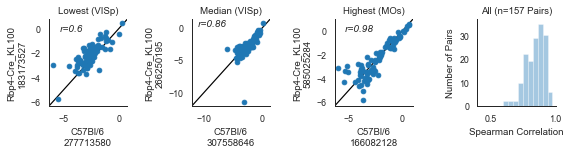

In [31]:
cr.name = 'cr'
plot_corrs(cr)

In [32]:
cr[cr['spearman_correlation'] < 0.5]

,sum_NPV_A,sum_NPV_B,dice_coefficient,pearson_correlation,match_A,fraction of match covered by td injection,absolute_overlap,distance,absolute_overlap_lg_over_small,spearman_correlation,...,same_secondary,<60% primary,same secondary for <60% primary,index_original,log_inj_size,log_ol,exp_predicted,low_pred_band,high_pred_band,sig


In [33]:
ce = c_by_source[((c_by_source['transgenic_line_A'] == 'C57Bl/6') & 
                 (c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre')) |
                ((c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre') &
                (c_by_source['transgenic_line_B'] == 'C57Bl/6'))]
for index, row in ce.iterrows():
    if(row['transgenic_line_B'] == 'Emx1-IRES-Cre'):
        ce.loc[index, ['match_A', 'match_B']] = ce.loc[index, ['match_B', 'match_A']]
        ce.loc[index,['match_A_injection_size','match_B_injection_size']] = ce.loc[
                index,['match_B_injection_size','match_A_injection_size']].values
        ce.loc[index,['fraction of match covered by td injection','injection_overlap']] = ce.loc[
                index,['injection_overlap','fraction of match covered by td injection']].values
        ce.loc[index,['transgenic_line_A','transgenic_line_B']] = ce.loc[
                index,['transgenic_line_B','transgenic_line_A']].values
        ce.loc[index,['Virus_A','Virus_B']] = ce.loc[
                index,['Virus_B','Virus_A']].values
        ce.loc[index,['match_A_primary_source','match_B_primary_source']] = ce.loc[
                index,['match_B_primary_source','match_A_primary_source']].values
        ce.loc[index,['match_A_secondary_source','match_B_secondary_source']] = ce.loc[
                index,['match_B_secondary_source','match_A_secondary_source']].values
        ce.loc[index,['match_A_percent_primary','match_B_percent_primary']] = ce.loc[
                index,['match_B_percent_primary','match_A_percent_primary']].values
        ce.loc[index,['match_A_percent_secondary','match_B_percent_secondary']] = ce.loc[
                index,['match_B_percent_secondary','match_A_percent_secondary']].values

In [34]:
print(ce['transgenic_line_A'].unique())
print(ce['transgenic_line_B'].unique())

['Emx1-IRES-Cre']
['C57Bl/6']


min A:  [277713580] B:  [562061175]
median A:  [479983421] B:  [307593747]
max A:  [479701339] B:  [309113907]


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


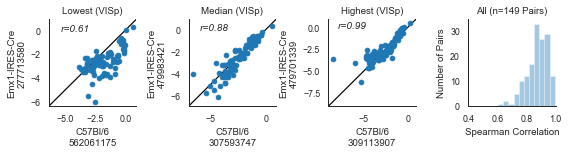

In [35]:
ce.name = 'ce'
plot_corrs(ce)

In [36]:
er = c_by_source[((c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100') & 
                 (c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre')) |
                ((c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre') &
                (c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100'))]
for index, row in er.iterrows():
    if(row['transgenic_line_B'] == 'Emx1-IRES-Cre'):
        er.loc[index, ['match_A', 'match_B']] = er.loc[index, ['match_B', 'match_A']]
        er.loc[index,['match_A_injection_size','match_B_injection_size']] = er.loc[
                index,['match_B_injection_size','match_A_injection_size']].values
        er.loc[index,['fraction of match covered by td injection','injection_overlap']] = er.loc[
                index,['injection_overlap','fraction of match covered by td injection']].values
        er.loc[index,['transgenic_line_A','transgenic_line_B']] = er.loc[
                index,['transgenic_line_B','transgenic_line_A']].values
        er.loc[index,['Virus_A','Virus_B']] = er.loc[
                index,['Virus_B','Virus_A']].values
        er.loc[index,['match_A_primary_source','match_B_primary_source']] = er.loc[
                index,['match_B_primary_source','match_A_primary_source']].values
        er.loc[index,['match_A_secondary_source','match_B_secondary_source']] = er.loc[
                index,['match_B_secondary_source','match_A_secondary_source']].values
        er.loc[index,['match_A_percent_primary','match_B_percent_primary']] = er.loc[
                index,['match_B_percent_primary','match_A_percent_primary']].values
        er.loc[index,['match_A_percent_secondary','match_B_percent_secondary']] = er.loc[
                index,['match_B_percent_secondary','match_A_percent_secondary']].values

In [37]:
print(er['transgenic_line_A'].unique())
print(er['transgenic_line_B'].unique())

['Emx1-IRES-Cre']
['Rbp4-Cre_KL100']


min A:  [522409371] B:  [603479758]
median A:  [503069254] B:  [479983421]
max A:  [503809372] B:  [501004474]


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


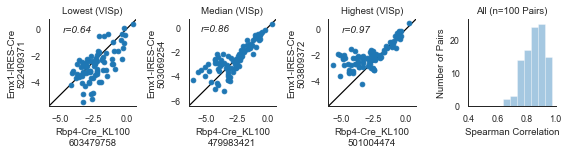

In [38]:
er.name = 'er'
plot_corrs(er)

min A:  [277713580] B:  [113887162]
median A:  [277616630] B:  [304586645]
max A:  [309372716] B:  [307558646]


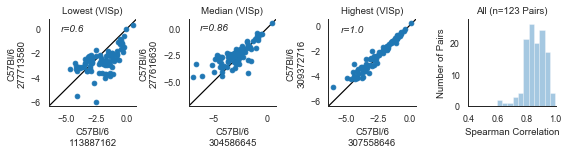

In [39]:
cc = c_by_source[(c_by_source['transgenic_line_A'] == 'C57Bl/6') & 
                 (c_by_source['transgenic_line_B'] == 'C57Bl/6')]
cc.name = 'cc'
plot_corrs(cc)

In [40]:
print(cc['transgenic_line_A'].unique())
print(cc['transgenic_line_B'].unique())

['C57Bl/6']
['C57Bl/6']


min A:  [522409371] B:  [601476074]
median A:  [562061175] B:  [501004474]
max A:  [479755622] B:  [479983421]


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


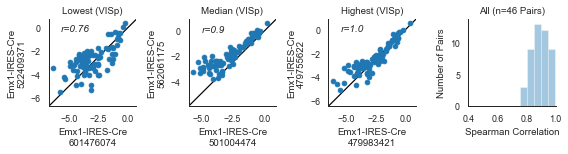

In [41]:
ee = c_by_source[(c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre') & 
                  (c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre')]
ee.name = 'ee'
plot_corrs(ee)

In [42]:
print(ee['transgenic_line_A'].unique())
print(ee['transgenic_line_B'].unique())

['Emx1-IRES-Cre']
['Emx1-IRES-Cre']


min A:  [503323656] B:  [530555292]
median A:  [648252402] B:  [166083557]
max A:  [125833030] B:  [496576666]


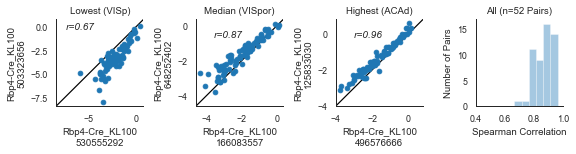

In [43]:
rr = c_by_source[(c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100') & 
                  (c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100')]
rr.name = 'rr'
plot_corrs(rr)

In [44]:
print(rr['transgenic_line_A'].unique())
print(rr['transgenic_line_B'].unique())

['Rbp4-Cre_KL100']
['Rbp4-Cre_KL100']


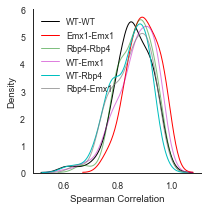

In [45]:
bins = np.linspace(0.1, 1, 20)
fig, ax = plt.subplots(figsize = (3, 3))
sns.distplot(cc['spearman_correlation'], bins = bins, hist = False, label = 'WT-WT',
            color = 'k', kde_kws={"linewidth": 1})
sns.distplot(ee['spearman_correlation'], bins = bins, hist = False, label = 'Emx1-Emx1', 
             color='r', kde_kws = {"linewidth": 1})
sns.distplot(rr['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Rbp4', 
             color='g', kde_kws = {"linewidth": 1, "alpha": 0.5})
sns.distplot(ce['spearman_correlation'], bins = bins, hist = False, label = 'WT-Emx1', 
            color='m', kde_kws = {"linewidth": 1, "alpha": 0.5})
sns.distplot(cr['spearman_correlation'], bins = bins, hist = False, label = 'WT-Rbp4', 
             color='c', kde_kws = {"linewidth": 1})
sns.distplot(er['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Emx1',
            color='gray', kde_kws = {"linewidth": 1, "alpha": 0.7})
ax.tick_params(top=False, right=False)
ax.legend(loc = 2, frameon = False)
ax.set_xlabel('Spearman Correlation')
ax.set_ylabel('Density')
sns.despine()

"\nplt.savefig(os.path.join(paperpath, 'kde_per_line_with_td.pdf'), \n        bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)\nplt.savefig(os.path.join(paperpath, 'kde_per_line_with_td.png'), \n        bbox_inches='tight', pad_inches=0.3, format='png', dpi=300)\n"

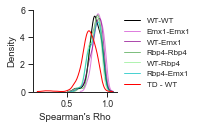

In [47]:
bins = np.linspace(0.1, 1, 20)
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.distplot(cc['spearman_correlation'], bins = bins, hist = False, label = 'WT-WT',
            color = 'k', kde_kws={"linewidth": 1})
sns.distplot(ee['spearman_correlation'], bins = bins, hist = False, label = 'Emx1-Emx1', 
             color='m', kde_kws = {"linewidth": 1, "alpha": 0.5})
sns.distplot(ce['spearman_correlation'], bins = bins, hist = False, label = 'WT-Emx1', 
            color='darkmagenta', kde_kws = {"linewidth": 1, "alpha": 0.7})
sns.distplot(rr['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Rbp4', 
             color='g', kde_kws = {"linewidth": 1, "alpha": 0.5})
sns.distplot(cr['spearman_correlation'], bins = bins, hist = False, label = 'WT-Rbp4', 
             color='lightgreen', kde_kws = {"linewidth": 1, "alpha": 0.7})
sns.distplot(er['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Emx1',
            color='c', kde_kws = {"linewidth": 1, "alpha": 0.7})
sns.distplot(alldat['spearman_correlation'], bins = bins, hist = False, label = 'TD - WT',
            color = 'r', kde_kws={"linewidth": 1})
ax.tick_params(top=False, right=False, bottom=True, left=True)
ax.legend(loc = 2, frameon = False, fontsize = 8, bbox_to_anchor = [1, 1])
ax.set_xlabel('Spearman\'s Rho')
ax.set_ylabel('Density')
sns.despine()

In [48]:
df = c_by_source[['match_A', 'match_B', 'transgenic_line_A', 'transgenic_line_B', 'spearman_correlation']]
df['tl'] = df[['transgenic_line_A', 'transgenic_line_B']].apply(lambda x: '_'.join(x), axis=1)

for index, row in df.iterrows():
    if(row['tl'] == 'Rbp4-Cre_KL100_C57Bl/6'):
        df.loc[index, 'tl'] = 'C57Bl/6_Rbp4-Cre_KL100'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values
    if(row['tl'] == 'Emx1-IRES-Cre_C57Bl/6'):
        df.loc[index, 'tl'] = 'C57Bl/6_Emx1-IRES-Cre'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values
    if(row['tl'] == 'Rbp4-Cre_KL100_Emx1-IRES-Cre'):
        df.loc[index, 'tl'] = 'Emx1-IRES-Cre_Rbp4-Cre_KL100'
        df.loc[index, ['match_A', 'match_B']] = df.loc[
            index, ['match_B', 'match_A']].values

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df = df[['match_A', 'match_B', 'spearman_correlation', 'tl']]

In [50]:
df1 = alldat[['image_series_id', 'match_id', 'spearman_correlation']]
df1.rename(columns = {'image_series_id': 'match_A', 'match_id': 'match_B'}, inplace = True)
df1['tl'] = 'target-defined'
df = pd.concat([df, df1])

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
df['tl'].unique()

array(['Emx1-IRES-Cre_Rbp4-Cre_KL100', 'C57Bl/6_Rbp4-Cre_KL100',
       'Rbp4-Cre_KL100_Rbp4-Cre_KL100', 'Emx1-IRES-Cre_Emx1-IRES-Cre',
       'C57Bl/6_Emx1-IRES-Cre', 'C57Bl/6_C57Bl/6', 'target-defined'],
      dtype=object)

In [57]:
# Make categorical variables for anova
df = df[['tl', 'spearman_correlation']]
df['tln']=df.tl.map({'C57Bl/6_C57Bl/6':1,'C57Bl/6_Rbp4-Cre_KL100':2, 'C57Bl/6_Emx1-IRES-Cre':3,
                    'Emx1-IRES-Cre_Rbp4-Cre_KL100':4, 'Emx1-IRES-Cre_Emx1-IRES-Cre':5,
                    'Rbp4-Cre_KL100_Rbp4-Cre_KL100':6, 'target-defined':7})
df.groupby('tln').describe()

spearman_correlation                                                    \
                   count      mean       std       min       25%       50%   
tln                                                                          
1                  123.0  0.856909  0.070165  0.596485  0.814276  0.855042   
2                  157.0  0.842754  0.072049  0.600291  0.788762  0.857977   
3                  149.0  0.871127  0.072858  0.605375  0.826451  0.880372   
4                  100.0  0.852215  0.071447  0.641079  0.798299  0.860610   
5                   46.0  0.895490  0.058389  0.755652  0.852316  0.895203   
6                   52.0  0.865261  0.062225  0.667222  0.817201  0.872873   
7                  586.0  0.777056  0.095607  0.208107  0.725525  0.783067   

                         
          75%       max  
tln                      
1    0.905867  0.997767  
2    0.897610  0.976025  
3    0.926837  0.993935  
4    0.909161  0.974469  
5    0.939885  0.995154  
6    0.915665  0.964012  
7    0.840576  0.995513

In [53]:
results = ols('spearman_correlation ~ C(tln)', df).fit()

In [54]:
aov_table = sm.stats.anova_lm(results)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(tln),6.0,2.191333,0.365222,52.437938,1.554013e-57
Residual,1206.0,8.399605,0.006965,NaN,NaN


In [55]:
print(sm.stats.multicomp.pairwise_tukeyhsd(results.model.endog, df['tln'].values))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  1      2    -0.0142  0.7711 -0.0438  0.0155 False 
  1      3     0.0142  0.777  -0.0158  0.0442 False 
  1      4    -0.0047   0.9   -0.0379  0.0285 False 
  1      5     0.0386  0.1056  -0.004  0.0812 False 
  1      6     0.0084   0.9   -0.0324  0.0491 False 
  1      7    -0.0799  0.001  -0.1043 -0.0554  True 
  2      3     0.0284  0.0473  0.0002  0.0566  True 
  2      4     0.0095   0.9   -0.0221  0.041  False 
  2      5     0.0527  0.0032  0.0114  0.0941  True 
  2      6     0.0225  0.6085 -0.0169  0.0619 False 
  2      7    -0.0657  0.001  -0.0878 -0.0435  True 
  3      4    -0.0189  0.5689 -0.0508  0.0129 False 
  3      5     0.0244  0.582  -0.0172  0.0659 False 
  3      6    -0.0059   0.9   -0.0456  0.0338 False 
  3      7    -0.0941  0.001  -0.1167 -0.0715  True 
  4      5     0.0433  0.0565 -0.0006  0.0872 

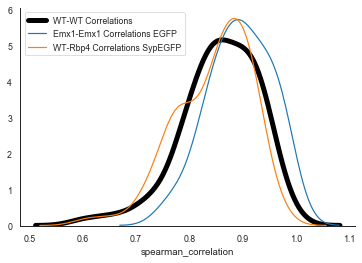

In [55]:
bins = np.linspace(0.1, 1, 20)
fig, ax = plt.subplots()
sns.distplot(cc['spearman_correlation'], bins = bins, hist = False, label = 'WT-WT Correlations',
            color = 'k', kde_kws={"linewidth": 5})
sns.distplot(ee['spearman_correlation'], bins = bins, hist = False, label = 'Emx1-Emx1 Correlations EGFP')
sns.distplot(cr['spearman_correlation'], bins = bins, hist = False, label = 'WT-Rbp4 Correlations SypEGFP')
ax.tick_params(top=False, right=False)
plt.legend(loc = 2)
sns.despine()

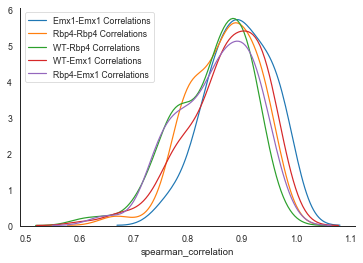

In [56]:
bins = np.linspace(0.1, 1, 20)
fig, ax = plt.subplots()
sns.distplot(ee['spearman_correlation'], bins = bins, hist = False, label = 'Emx1-Emx1 Correlations')
sns.distplot(rr['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Rbp4 Correlations')
sns.distplot(cr['spearman_correlation'], bins = bins, hist = False, label = 'WT-Rbp4 Correlations')
sns.distplot(ce['spearman_correlation'], bins = bins, hist = False, label = 'WT-Emx1 Correlations')
sns.distplot(er['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Emx1 Correlations')
ax.tick_params(top=False, right=False)
plt.legend(loc = 2)
sns.despine()

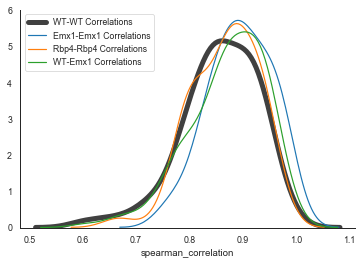

In [57]:
bins = np.linspace(0.1, 1, 20)
fig, ax = plt.subplots()
sns.distplot(cc['spearman_correlation'], bins = bins, hist = False, label = 'WT-WT Correlations',
            color = 'k', kde_kws={"linewidth": 5, 'alpha': 0.75, 'zorder': -1})
sns.distplot(ee['spearman_correlation'], bins = bins, hist = False, label = 'Emx1-Emx1 Correlations')
sns.distplot(rr['spearman_correlation'], bins = bins, hist = False, label = 'Rbp4-Rbp4 Correlations')
sns.distplot(ce['spearman_correlation'], bins = bins, hist = False, label = 'WT-Emx1 Correlations')
ax.tick_params(top=False, right=False)
plt.legend(loc = 2)
sns.despine()